## Imports

In [4]:
import os
import sys
import numpy as np
import time
import scipy
import matplotlib.pyplot as plt
import time
from scipy.stats import binned_statistic

In [6]:
# import the frank2d directory
current_dir =  os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
sys.path.append(parent_dir)

#frank2d
from frank2d import Frank2D
from constants import rad_to_arcsec
from plot import Plot
from fitting import IterativeSolverMethod

# frank1d
import frank
from frank.geometry import FixedGeometry, SourceGeometry, FitGeometryGaussian
from frank.radial_fitters import FrankFitter
from frank.utilities import UVDataBinner

### Functions

In [7]:
def deproject(u, v, inc, PA, inverse=False):
    r"""
    Deproject the image in visibily space

    Parameters
    ----------
    u : array of real, size = N, unit = :math:`\lambda`
        u-points of the visibilities
    v : array of real, size = N, unit = :math:`\lambda`
        v-points of the visibilities
    inc : float, unit = deg
        Inclination
    PA : float, unit = deg
        Position angle, defined east of north.
    inverse : bool, default=False
        If True, the uv-points are reprojected rather than deprojected

    Returns
    -------
    up : array, size = N, unit = :math:`\lambda`
        Deprojected u-points
    vp : array, size = N, unit = :math:`\lambda`
        Deprojected v-points
    wp : array of real, size = N, unit = :math:`\lambda`
        Fourier w-points of the deprojected visibilities. Only returned if
        deprojecting.

    """
    deg_to_rad = np.pi / 180
    inc *= deg_to_rad
    PA *= deg_to_rad

    cos_t = np.cos(PA)
    sin_t = np.sin(PA)

    if inverse:
        sin_t *= -1
        u = u / np.cos(inc)

    up = u * cos_t - v * sin_t
    vp = u * sin_t + v * cos_t

    if inverse:
        return up, vp
    else:
    #   Deproject
        wp = up * np.sin(inc)
        up = up * np.cos(inc)

        return up, vp, wp

In [8]:
 def apply_correction(self, u, v, V, use3D=False):
        r"""
        Correct the phase centre and deproject the visibilities

        Parameters
        ----------
        u : array of real, size = N, unit = :math:`\lambda`
            u-points of the visibilities
        v : array of real, size = N, unit = :math:`\lambda`
            v-points of the visibilities
        V : array of real, size = N, units = Jy
            Complex visibilites
        use3D : bool, default=False
            If True, also return the 3rd compoent of the
            de-projected visibilities, wp.

        Returns
        -------
        up : array of real, size = N, unit = :math:`\lambda`
            Corrected u-points of the visibilities
        vp : array of real, size = N, unit = :math:`\lambda`
            Corrected v-points of the visibilities
        wp : array of real, size = N, unit = :math:`\lambda`
            [Optional] Corrected w-points of the visibilities
        Vp : array of real, size = N, unit = Jy
            Corrected complex visibilites

        """
        Vp = apply_phase_shift(u, v, V, self._dRA, self._dDec, inverse=True)
        up, vp, wp = deproject(u, v, self._inc, self._PA)

        if use3D:
            return up, vp, wp, Vp
        else:
            return up, vp, Vp

In [9]:
def get_radial_profile(frank_object):
    x = frank_object._FT._Xn*rad_to_arcsec
    y = frank_object._FT._Yn*rad_to_arcsec
    pixel_size = (x[1]-x[0])
    r = np.hypot(x, y)
    I = frank_object.sol_intensity
    r = r.flatten()
    I = I.flatten()
    N = frank_object._Nx
    bin = (np.max(r) - np.min(r))/N
    I_binned, bin_edges, _ = binned_statistic(r, I, 'mean', N)
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return r_centers, I_binned

def get_vis_profile(frank_object):
    u = frank_object._FT._Un
    v = frank_object._FT._Vn
    pixel_size = (u[1]-u[0])
    q = np.hypot(u, v)
    Vis = frank_object.sol_visibility
    q = q.flatten()
    Vis = Vis.flatten()
    N = frank_object._Nx
    bin = (np.max(q) - np.min(q))/N
    weights_gridded = frank_object._gridded_data['weights']
    Vis_binned, bin_edges, _ = binned_statistic(q, Vis, 'mean', N)
    Vis_Weights_binned, bin_edges, _ = binned_statistic(q, Vis*weights_gridded, 'sum', N)
    Weights_binned, bin_edges, _ = binned_statistic(q, weights_gridded, 'sum', N)
    q_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    return q_centers, Vis_Weights_binned/Weights_binned

### Data

In [10]:
# Huang 2018 
inc = 34.97
pa = 85.76
dra = 1.9e-3
ddec = -2.5e-3
Rout = 2 #arcsecs

# UVtable
dir = "../../../data/"
data_file = dir +'AS209_continuum_prom_1chan_30s_keepflagsFalse.txt'

 # load data||
u, v, Re, Imag, Weights = np.loadtxt(data_file, unpack = True)
Vis = Re + Imag*1j

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
u_deproj, v_deproj, vis_deproj = geom.apply_correction(u, v, Vis)

In [11]:
N = 50

In [12]:
matrixSE = SE_kernel()

NameError: name 'SE_kernel' is not defined

In [ ]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(7,7))
plt.imshow(matrixSE, cmap =  'magma', norm=LogNorm(vmin = 1e-10, vmax= 1e-20))
plt.colorbar(shrink=0.8)
plt.xlim(1150, 1350)
plt.ylim(1350, 1150)
plt.title(r'Square Exponential in fourier space', size = 10)
plt.show()

In [46]:
if np.all(np.linalg.eigvals(matrixSE) > 0): print("definite positive")

KeyboardInterrupt: 

In [47]:
np.max(matrixSE)

1.0

In [ ]:
plt.figure(figsize=(7,1))
plt.plot(q_f, np.full(len(q_f), 1), ls = 'None', marker = 'x')
plt.xscale('log')
plt.show()

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(q_f, matrixSE.flatten(), ls = 'None', marker = 'x')
plt.yscale('log')
#plt.xscale('log')
#plt.xlim(-1e1, 1e1)
plt.show()

In [ ]:
H = 1e4
amplitude = 1

In [ ]:
matrixW = Wendland_kernel(amplitude, H)

In [ ]:
if np.all(np.linalg.eigvals(matrixW) > 0): print("definite positive")

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(q_f, matrixW.flatten(), ls = 'None', marker = 'x', label = f'l = {4*l:.0e}')
#plt.yscale('log')
#plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
plt.imshow(matrixW, cmap =  'magma', vmin = 0, vmax = 0.00025)
plt.colorbar(shrink=0.8)
plt.title(r'Wendland kernel', size = 10)
plt.show()

In [56]:
def Wendland_kernel_fit(input, amp, h, l = 3, k = 1):
    u1, u2 = np.meshgrid(input[0], input[0])
    v1, v2 = np.meshgrid(input[1], input[1])
    r = np.sqrt((u1-u2)**2 + (v1-v2)**2)
    r_normalized = r/h

    factor = (1 - r_normalized)**(l)
    factor[r_normalized > 1] = 0

    return (amp * factor * P_k(r_normalized, k)).flatten()

In [57]:
from scipy.optimize import curve_fit

se_kernel_values = matrixSE.flatten()

initial_guess = [0.025, 5e5] 
u, v = frank2d._FT._Un, frank2d._FT._Vn
params_opt, params_cov = curve_fit(Wendland_kernel_fit, [u,v] , se_kernel_values, p0=initial_guess)

amp_opt, h_opt = params_opt
print(f"Optimal parameters: amp = {amp_opt}, h = {h_opt}")

Optimal parameters: amp = 0.009990369249680536, h = 49473.54725195536


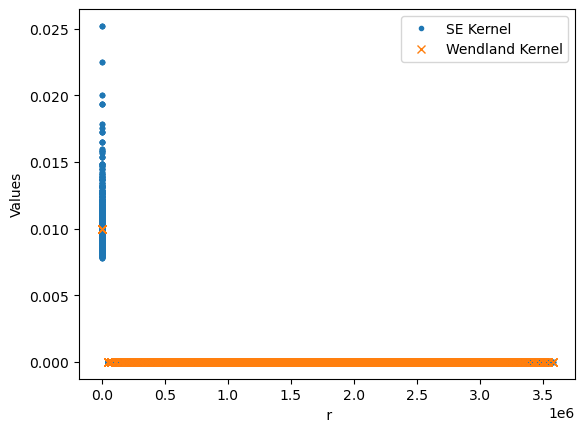

In [58]:
wendland_fitted = Wendland_kernel_fit([u,v], amp_opt, h_opt)

plt.plot(q.flatten() , se_kernel_values, label='SE Kernel', ls = 'None', marker = '.',)
plt.plot(q.flatten() , wendland_fitted, label='Wendland Kernel', ls = 'None', marker = 'x',)
plt.xlabel(' r')
#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Values')
plt.legend()
plt.show()

In [59]:
matrixW_opt = Wendland_kernel([u, v],  amp_opt, h_opt)

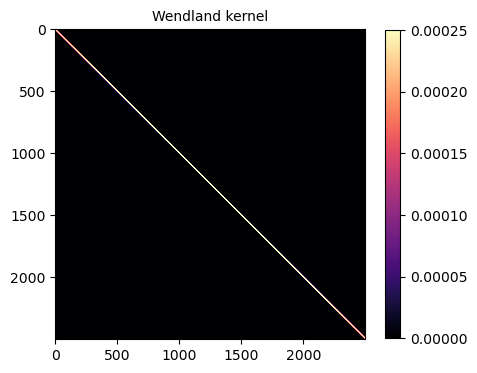

In [61]:
plt.figure(figsize=(5,5))
plt.imshow(matrixW_opt, cmap =  'magma', vmin = 0, vmax = 0.00025)
plt.colorbar(shrink=0.8)
plt.title(r'Wendland kernel', size = 10)
plt.show()

In [17]:
start_time = time.time()

#####

frank2d = Frank2D(N, Rout)
frank2d.set_kernel('Wendland', [4, 1, 1, 2e4])
frank2d.fit(u_deproj, v_deproj, vis_deproj, Weights, method = 'cg', rtol = '1e-15')

#####
print("--------------------------------------")
end_time = time.time()
execution_time = end_time - start_time
print(f'time = {execution_time/60 :.2f}  min | {execution_time: .2f} seconds')

Setting kernel...Wendland
 Wendland Kernel with params =  [4, 1, 1, 20000.0]
Gridding...


/Users/mariajmelladot/Desktop/Frank2D/6_Frank2D_Oficial/frank2d/preprocess_vis.py:42: RuntimeWarning: invalid value encountered in divide
  vis_gridded_matrix =  vis_weights_sum_bin/weights_sum_bin


  --> time = 0.00  min |  0.24 seconds
Setting fit with cg ...
Setting guess... Visibilities gridded
Fitting...
  *  Constructing linear operators...
     --> time = 0.00  min |  0.05 seconds
  *  Solving linear system...
         * rtol: 1e-15
         * final tolerance: 9.976337953654204e-08
maxiter:  20
iteration:  0
iteration:  1
  --> CGM converged in  1  iterations
     --> time = 0.00  min |  0.07 seconds
  --> CGM converged?   True
  --> Fit correctly?   True
                                    !!!!!!!!!!!!!!!!!!!
Inverting with 2fft ...
  --> time = 0.00  min |  0.00 seconds
--------------------------------------
time = 0.01  min |  0.74 seconds


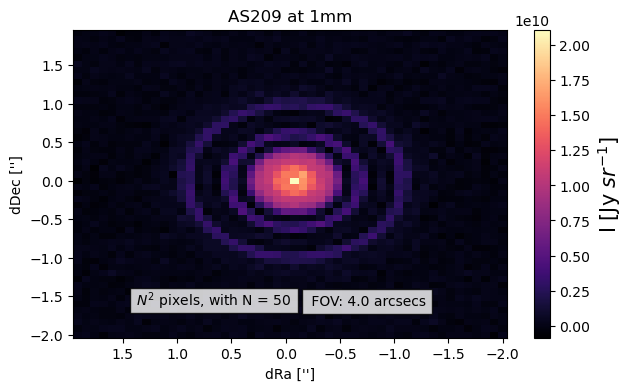

In [18]:
Plot(frank2d).get_image('AS209 at 1mm')

In [98]:
u_gridded = frank2d._gridded_data['u']
v_gridded = frank2d._gridded_data['v']
vis_gridded = frank2d._gridded_data['vis']

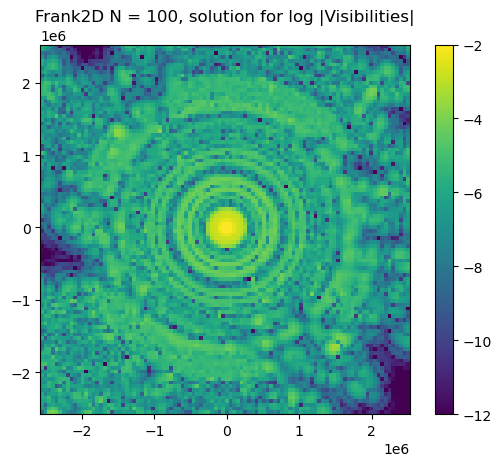

In [99]:
extent=[u_gridded.min(), u_gridded.max(), v_gridded.min(), v_gridded.max()]
plt.imshow(np.log(np.abs(np.fft.fftshift(frank2d.sol_visibility.real.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(F'Frank2D N = {N}, solution for log |Visibilities|')
plt.colorbar()

/var/folders/ng/vs__trg57hl3mtgq5kgkzj4h0000gn/T/ipykernel_5329/2256721134.py:2: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)


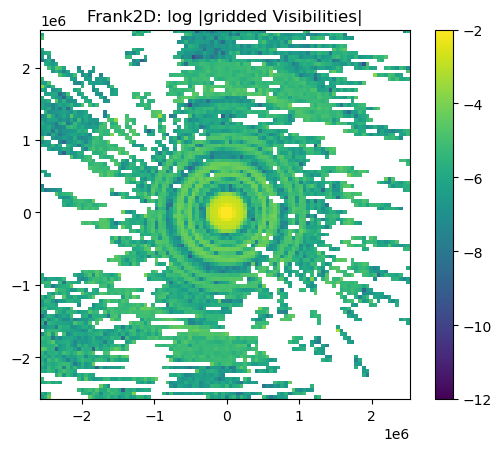

In [100]:
plt.figure()
plt.imshow(np.log(np.abs(np.fft.fftshift(vis_gridded.reshape(N, N)))), extent=extent, origin='lower', vmin=-12, vmax=-2)
plt.title(f'Frank2D: log |gridded Visibilities|')
plt.colorbar()

In [101]:
r, I = get_radial_profile(frank2d)

In [87]:
# Frank 1D Parameters
n_pts = 300
alpha = 1.3
w_smooth = 1e-1

geom = SourceGeometry(inc= inc, PA= pa, dRA= dra, dDec= ddec)
FF = FrankFitter(Rout, n_pts, geom, alpha = alpha, weights_smooth = w_smooth)
sol = FF.fit(u, v, Vis, Weights)

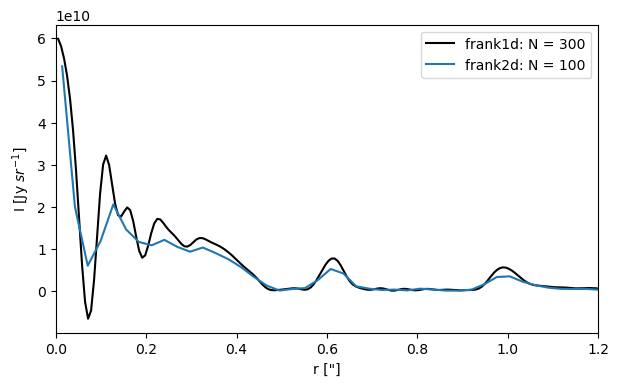

In [102]:
plt.figure(figsize=(7,4))
plt.plot(sol.r, sol.mean, 'black',label =f'frank1d: N = {n_pts}')
plt.plot(r, I, label = f'frank2d: N = {N}')
plt.xlabel('r ["]')
plt.xlim(0, 1.2)           
plt.ylabel(r'I [Jy $sr^{-1}$]')
plt.legend()
plt.show()

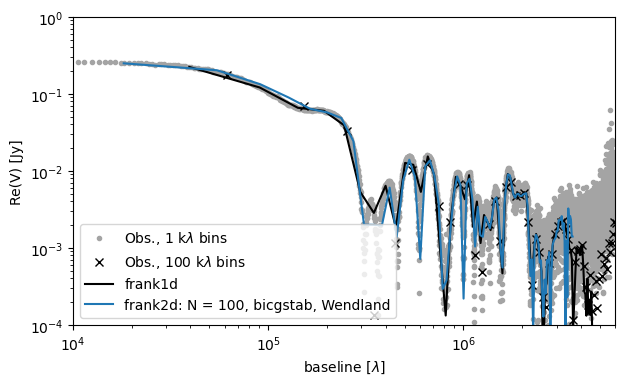

In [104]:
cs, ms = ['#a4a4a4', 'k'], ['.', 'x']
bin_widths=[1e3, 1e5]
baselines = np.hypot(u_deproj, v_deproj)         
grid = np.logspace(np.log10(min(baselines.min(), baselines[0])),
                           np.log10(max(baselines.max(), baselines[-1])),
                           10**4)

plt.figure(figsize=(7,4))

for i in range(len(bin_widths)):
            binned_vis = UVDataBinner(baselines, vis_deproj, Weights, bin_widths[i])
            plt.plot(binned_vis.uv, np.abs(binned_vis.V), c=cs[i],
                         marker=ms[i], ls='None', 
                         label=r'Obs., {:.0f} k$\lambda$ bins'.format(bin_widths[i]/1e3))


#frank1d
vis_fit_1d = sol.predict_deprojected(sol.q)
baselines_fit_1d = sol.q
plt.plot(baselines_fit_1d, np.abs(vis_fit_1d), color = "black", label = r'frank1d')

#frank2d
q, Vis_1= get_vis_profile(frank2d)
plt.plot(q, np.abs(Vis_1.real), label = f'frank2d: N = {N}, bicgstab, Wendland')

plt.xlabel(r'baseline [$\lambda$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-4, 1)
plt.xlim(1e4, 6e6)
plt.ylabel('Re(V) [Jy]', size = 10)
plt.legend()
plt.show()